[1.58113883 1.58113883 1.58113883 1.58113883 1.58113883 1.58113883]
[1. 0. 0. 0.] [-1.00000000e+00  1.11022302e-16  0.00000000e+00  0.00000000e+00]
[[-1  1]]
[[ 1.        -0.5       -0.5      ]
 [ 0.        -0.8660254  0.8660254]]
[[ 1.         -0.33333333 -0.33333333 -0.33333333]
 [ 0.          0.94280904 -0.47140452 -0.47140452]
 [ 0.          0.         -0.81649658  0.81649658]]


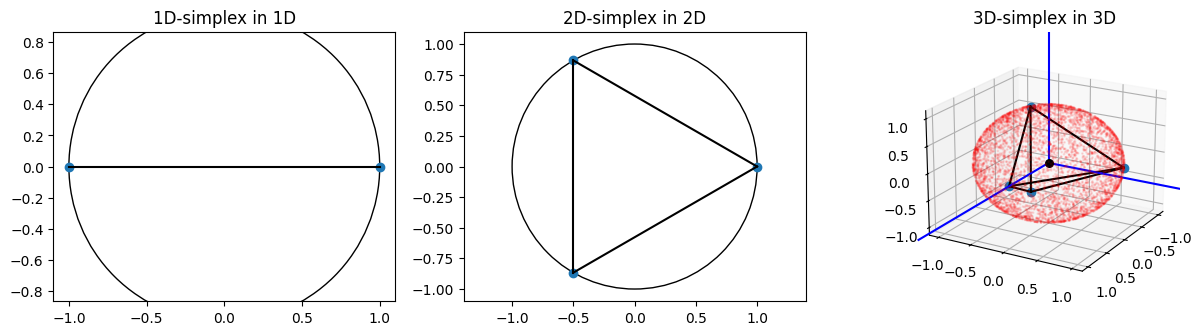

True

In [2]:

import abc
from typing import Any, cast
import numpy as np
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
import abc

# dist = UniformIsotropicDistribution(2, r=2)
# print(dist.norm_rms())
# dist = GaussianIsotropicDistribution(2, r=2)
# print(dist.norm_rms())


def dists_all_vs_all(V):
    d = V.shape[0]
    return np.array([np.linalg.norm(V[i]-V[j]) for i in range(d) for j in range(i+1, d)])

def plot_simplex_1_3():
    fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))
    for ax, d in [(axes[0], 1), (axes[1], 2), (axes[2], 3)]:
        if d==3:
            # Delete this plot
            ax.remove()
            # Make a 3d plot centered at the origin
            ax = fig.add_subplot(133, projection='3d')
            ax.view_init(elev=20, azim=30) # type: ignore
        else:
            ax.add_artist(plt.Circle((0, 0), 1, fill=False))# type: ignore
        ax.axis('equal')
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(-1.1, 1.1)
        if d==3:
            ax.set_zlim(-1.1, 1.1) # type: ignore
        ax.set_title(f"{d}D-simplex in {d}D")
        V = simplex_vertices_in_d_dimensions(d)
        print(V)
        if d==1:
            # Add zeroes to each column vector
            V = np.concatenate([V, np.zeros((1, d+1))])
        if d==1 or d==2:
            ax.plot(*V, 'o')
            for i,j in ((i,j) for i in range(d+1) for j in range(i+1, d+1)):
                ax.plot(*V[:,[i,j]], 'k-')
        else:
            # set 3d projection for axes[2]
            ax.plot(*V, 'o')
            for i,j in ((i,j) for i in range(d+1) for j in range(i+1, d+1)):
                ax.plot(*V[:,[i,j]], 'k-')
            # Plot a 3d sphere
            X = np.random.normal(size=(5000, 3))
            X /= np.linalg.norm(X, axis=1)[:, None]
            ax.scatter(X[:,0], X[:,1], X[:,2], s=1, c='r', alpha=0.1)# type: ignore
            ax.scatter(*np.zeros((3,1)), c='k', s=30)# type: ignore
            for v in 3*np.eye(3):
                ax.plot(*np.array([np.zeros(3), v]).T, 'b-')
    plt.show()

def simplex_vertices_in_d_dimensions(d:int):
    # The columns of V are the vertices of the d-dimensional simplex
    assert d > 0
    V = np.array([[-1, 1]])
    k = 2
    while k <= d:
        V_i = [([-1/k, *(np.sqrt(k**2-1)/k*u)]) for u in V.T]
        v_k = [1, *np.zeros(k-1)]
        V = np.array([v_k, *V_i]).T
        k += 1
    return V

f = lambda d: np.array([[-1], [1]] if d<=1 else [[1, *[0]*(d-1)], *[([-1/d, *((d**2-1)**.5/d*u)]) for u in f(d-1).T]]).T

V = simplex_vertices_in_d_dimensions(4)
print(dists_all_vs_all(V))
print(V[:,0], V[:,1:].sum(axis=1))
plot_simplex_1_3()

np.allclose(f(4), simplex_vertices_in_d_dimensions(4))


In [275]:

from typing import Literal


class CategoricalSimplex:
    '''
    Embedding for a categorical variable with d categories. There are three types of embeddings:
    - The "categorical space" (cat), where each category is an integer from 0 to d-1
    - The "one-hot space" (oh) or "affine space", where each category is a one-hot vector (in d-dimensions)
    - The "linear space" (lin), where each category is a point in (d-1)-dimensions
    '''

    def __init__(self,
                 n_cat:int,
                 lin_scale:float|Literal['unit_side', 'match_oh']='match_oh', 
                 oh_scale:float|Literal['unit_side', 'match_lin']=1,
                 ):
        '''
        lin_scale: float or 'unit_side' or 'match_oh'
            Radius of the simplex in the linear space.
        oh_scale: float or 'unit_side' or 'match_lin'
            Norm of the one-hot-encoded vectors in the one-hot space.
        '''
        self.n_cat = n_cat
        self.d = d = n_cat-1 # Dimensionality of the simplex

        # Default scales. Caution: side and radius scale simultaneously but not vertex_norm because of the affine map
        dt_scales = np.dtype([('vertex_norm', float), ('side', float), ('radius', float), ('factor', float)])
        Scale = lambda values, by: np.array(tuple(by*np.array(values.tolist())), dtype=dt_scales)
        s_oh = Scale(np.array([1, np.sqrt(2), np.sqrt(d/(d+1)), 1]), 1.0)
        s_lin =  Scale(np.array([1, s_oh['side']/s_oh['radius'], 1, 1]), 1.0)
        s_lin['factor'] = 1
        
        # Parse the scale arguments
        f = lambda x, ref: cast(float|None,1/ref['side'] if x =='unit_side' else None if isinstance(x,str) else x)
        _s_lin = f(lin_scale, s_lin)
        _s_oh = f(oh_scale, s_oh)
        if _s_lin is None or _s_oh is None:
            if _s_lin is not None:
                s_lin = Scale(s_lin, _s_lin)
                s_oh = Scale(s_oh, s_lin['radius'] / s_oh['radius'])
            elif _s_oh is not None:
                s_oh = Scale(s_oh, _s_oh)
                s_lin = Scale(s_lin, s_oh['radius'] / s_lin['radius'])
            else:
                raise Exception("Cannot have match_oh and match_lin simultaneously")
        else:
            s_lin = Scale(s_lin, _s_lin)
            s_oh = Scale(s_oh, _s_oh)
        self.lin_scale = s_lin
        self.oh_scale = s_oh

        # The columns of V are the vertices of the simplex
        V = simplex_vertices_in_d_dimensions(d)
        self.isometry = np.sqrt(d/(d+1)) * V

        self.lin_vertices = self.lin_scale['vertex_norm'] * V
        self.oh_vertices = self.oh_scale['vertex_norm'] * np.eye(d+1)
        self.oh_centroid = np.mean(self.oh_vertices, axis=0)
        self.lin_volume = np.sqrt((d+1)/2**d) / scipy.special.gamma(1+d) * self.lin_scale['side']**d
        self.oh_volume = np.sqrt((d+1)/2**d) / scipy.special.gamma(1+d) * self.oh_scale['side']**d

    def cat_to_oh(self, X_cat:np.ndarray):
        N = len(X_cat)
        assert np.all(np.isclose(X_cat, X_cat.astype(int))), X_cat
        X_cat = X_cat.astype(int)
        if len(X_cat.shape)==2 and X_cat.shape[-1]==1:
            X_cat = X_cat[:,0]
        Y = np.zeros((N, self.n_cat))
        Y[np.arange(N), X_cat.astype(int)] = self.oh_scale['vertex_norm']
        return Y
    
    def cat_to_lin(self, X_cat:np.ndarray):
        return self.lin_vertices.T[X_cat]
    
    def oh_to_cat(self, X:np.ndarray):
        return np.argmax(X, axis=-1)
    
    def lin_to_cat(self, X:np.ndarray):
        X_OH = self.lin_to_oh(X)
        return self.oh_to_cat(X_OH)

    def oh_to_lin(self, X_oh:np.ndarray):
        # X_oh has rows of one-hot vectors
        X_oh = X_oh / self.oh_scale['side']
        X_lin = np.matmul(X_oh, self.isometry.T)
        return X_lin * self.lin_scale['side']
    
    def lin_to_oh(self, X_lin:np.ndarray):
        X_lin = X_lin / self.lin_scale['side']
        X_oh = np.matmul(X_lin, self.isometry)
        return X_oh * self.oh_scale['side'] + self.oh_centroid
    

    

s = CategoricalSimplex(4, lin_scale=np.pi*np.e, oh_scale='match_lin')
print(s.lin_scale, s.oh_scale)

print(np.allclose(np.linalg.norm(s.lin_vertices.T, axis=-1), s.lin_scale['vertex_norm']))
print(np.allclose(np.linalg.norm(s.oh_vertices.T, axis=-1), s.oh_scale['vertex_norm']))
print(np.allclose(s.lin_to_oh(s.lin_vertices.T), s.oh_vertices.T))
print(np.allclose(s.oh_to_lin(s.oh_vertices.T), s.lin_vertices.T))
print(np.allclose(dists_all_vs_all(s.lin_vertices), s.lin_scale['side']))
print(np.allclose(dists_all_vs_all(s.oh_vertices), s.oh_scale['side']))


w = np.random.random((10, 4))
w /= w.sum(axis=1, keepdims=True)
w *= s.oh_scale['vertex_norm']
print(np.allclose(s.lin_to_oh(s.oh_to_lin(w)), w))


print(s.lin_to_oh(s.lin_vertices.T).round(4))
print(s.oh_to_lin(s.oh_vertices.T).round(4))

# # print(s.oh_to_lin(s.oh_centroid))

# X4 = s.oh_vertices
# X4 = np.concatenate([X4, np.ones((1,4)), np.zeros((1,4)), [(X4[0]+X4[1])/2, X4[0]*2]])
# X3 = s.oh_to_lin(X4)
# print(np.linalg.norm(X3, axis=-1).round(3), s.lin_scale['vertex_norm'])

# print(s.lin_to_oh(X3).round(4))
# print(np.linalg.norm(s.lin_to_oh(X3), axis=-1).round(3), s.oh_scale['vertex_norm'])
# # X4_again = s.lin_to_oh(X3)
# # print(X4_again)
# # # print(s.linear_to_one_hot(s.one_hot_to_linear(np.array([0,0,1,0]))))

s = CategoricalSimplex(4, lin_scale=10, oh_scale=1)
x_cat = np.random.randint(0, 4, 100)
print(x_cat[:5])
print(s.cat_to_oh(x_cat)[:5])
print(s.cat_to_lin(x_cat)[:5])
print(np.allclose(s.lin_to_cat(s.cat_to_lin(x_cat)), x_cat))
print(np.allclose(s.oh_to_cat(s.cat_to_oh(x_cat)), x_cat))

(8.53973422, 13.94532759, 8.53973422, 8.53973422) (9.8608357, 13.94532759, 8.53973422, 9.8608357)
True
True
True
True
True
True
True
[[ 9.8608  0.      0.      0.    ]
 [ 0.      9.8608 -0.     -0.    ]
 [ 0.     -0.      9.8608  0.    ]
 [ 0.     -0.      0.      9.8608]]
[[ 8.5397  0.      0.    ]
 [-2.8466  8.0513  0.    ]
 [-2.8466 -4.0257 -6.9727]
 [-2.8466 -4.0257  6.9727]]
[2 0 2 2 3]
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[-3.33333333 -4.71404521 -8.16496581]
 [10.          0.          0.        ]
 [-3.33333333 -4.71404521 -8.16496581]
 [-3.33333333 -4.71404521 -8.16496581]
 [-3.33333333 -4.71404521  8.16496581]]
True
True
